In [46]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os 
import random
import numpy as np 

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 图像的Normalize

In [48]:
data_trans=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [49]:
data_trans_227=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [50]:
data_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [51]:
data_test_227=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [52]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=data_trans)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [54]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [55]:
print(len(train_data),len(valid_data),len(test_data))

45000 5000 10000


In [56]:
batch_size=64

In [57]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

# 定义DenseNet121模型

In [58]:
import torch.nn.init as init
class Fire(nn.Module):
    def __init__(self,inplanes,s1,e1,e3):
        super(Fire,self).__init__()
        self.inplanes=inplanes
        self.squeeze=nn.Conv2d(inplanes,s1,kernel_size=1)
        self.squeeze_activation=nn.ReLU(inplace=True)
        self.expand1x1=nn.Conv2d(s1,e1,kernel_size=1)
        self.expand1x1_activation=nn.ReLU(inplace=True)
        self.expand3x3=nn.Conv2d(s1,e3,kernel_size=True)
        self.expand3x3_activation=nn.ReLU(inplace=True)
    def forward(self,x):
        x=self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ],1)
class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=10):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            #nn.ReLU(inplace=True),
            #nn.AvgPool2d(4, stride=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal(m.weight.data, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

# 载入模型并训练

In [59]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
model_dir='/content/drive/My Drive/Colab Notebooks/models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [61]:
device

device(type='cuda')

In [62]:
model=SqueezeNet().to(device)
model_path=os.path.join(model_dir,'squeezenet_c10.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [63]:
optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

## 定义计算精确度方法

In [64]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

## 定义训练方法

In [65]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 定义评测方法

In [66]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [67]:
epochs=30
best_valid_loss=float('inf')

In [68]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:1.999544039199298|Train Acc:0.21147017045454544|Val Loss:1.8890452566026132|Val Acc:0.25850474683544306
Epoch:2|Train Loss:1.872185166078535|Train Acc:0.26087535511363635|Val Loss:1.8813851045656809|Val Acc:0.26720727848101267
Epoch:3|Train Loss:1.8128037447617813|Train Acc:0.2861106178977273|Val Loss:1.800175666809082|Val Acc:0.294501582278481
Epoch:4|Train Loss:1.7656781422820957|Train Acc:0.31001420454545453|Val Loss:1.8458486206923859|Val Acc:0.29252373417721517
Epoch:5|Train Loss:1.7428522695871917|Train Acc:0.3225985440340909|Val Loss:1.809807988661754|Val Acc:0.30122626582278483
Epoch:6|Train Loss:1.7193928567523307|Train Acc:0.33280806107954547|Val Loss:1.6950288181063495|Val Acc:0.34335443037974683
Epoch:7|Train Loss:1.6983558657494457|Train Acc:0.34239612926136365|Val Loss:1.6641620427747317|Val Acc:0.3494857594936709
Epoch:8|Train Loss:1.6760723678903147|Train Acc:0.35298295454545453|Val Loss:1.6574143910709815|Val Acc:0.3738132911392405
Epoch:9|Train Loss

In [69]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 1.4651010886878724 | Test Acc: 0.45421974522292996 |


# 模型的评测

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [71]:
prediction=[]
groundtruth=[]

In [72]:
def evaluate2(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            prediction.append(fx)
            groundtruth.append(y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [73]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate2(model, device, test_iterator, criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 1.4629283156364588 | Test Acc: 0.45551353503184716 |


In [74]:
pred=torch.cat(prediction).cpu().numpy()

In [75]:
pred.shape

(10000, 10)

In [76]:
pred[0]

array([-0.98151475, -0.66803664, -0.41270947,  0.08505507, -0.26433927,
       -0.40817595,  0.49604586, -0.52581847, -1.1230457 , -0.2037543 ],
      dtype=float32)

In [77]:
gt=torch.cat(groundtruth).cpu().numpy()

In [78]:
gt.shape

(10000,)

In [79]:
fpr=dict()
tpr=dict()
prc=dict()
rcl=dict()
roc_auc=dict()
ap=dict()

In [80]:
gt_one_hot=np.eye(10)[gt.reshape(-1)]#groundtruth的onehot化

In [81]:
gt_one_hot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [82]:
pred_soft=F.softmax(torch.cat(prediction).cpu()).cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [83]:
pred_soft[0]

array([0.05033553, 0.06886784, 0.08890039, 0.14624467, 0.1031193 ,
       0.08930434, 0.2205825 , 0.07939278, 0.04369267, 0.10955992],
      dtype=float32)

In [84]:
for i in range(10):
    fpr[i],tpr[i],_=roc_curve(gt_one_hot[:,i],pred_soft[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
    prc[i],rcl[i],_=precision_recall_curve(gt_one_hot[:,i],pred_soft[:,i])
    ap[i]=average_precision_score(gt_one_hot[:,i],pred_soft[:,i])

In [85]:
tpr[0].shape

(1308,)

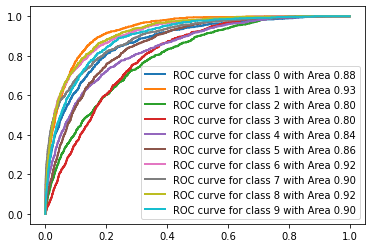

In [86]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.legend()

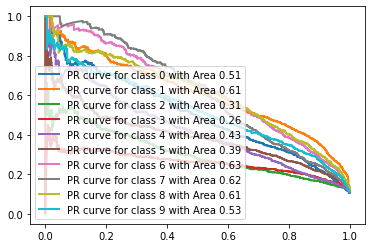

In [87]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.legend()

## Micro的实现

Micro认为所有的分类1......k都是同一类，因此将所有的gt和预测的结果合并成为1个数组来进行评判

In [88]:
gt_one_hot.ravel().shape

(100000,)

In [89]:
pred_soft.ravel().shape

(100000,)

In [90]:
fpr['micro'],tpr['micro'],_=roc_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [91]:
prc['micro'],rcl['micro'],_=precision_recall_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [92]:
ap['micro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='micro')

In [93]:
roc_auc['micro']=auc(fpr['micro'],tpr['micro'])

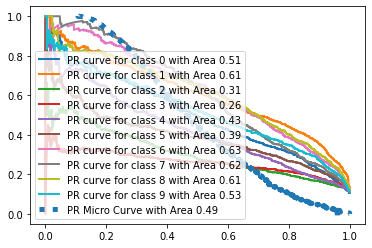

In [94]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
    
plt.legend()

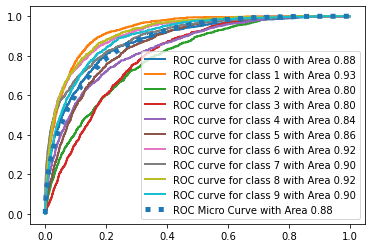

In [95]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
 
plt.legend()

## Macro的计算

In [96]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(10)]))#获得所有的fpr插值点

In [97]:
np.concatenate([fpr[i] for i in range(10)]).shape

(13150,)

In [98]:
all_prc=np.unique(np.concatenate([prc[i] for i in range(10)]))#获得所有的prc的插值点

In [99]:
mean_tpr=np.zeros_like(all_fpr)
mean_rcl=np.zeros_like(all_prc)

In [100]:
mean_tpr.shape

(3225,)

In [101]:
for i in range(10):
    mean_tpr+=interp(all_fpr,fpr[i],tpr[i])
    mean_rcl+=interp(all_prc,prc[i],rcl[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
mean_tpr/=10

In [103]:
mean_rcl/=10

In [104]:
fpr['macro']=all_fpr
prc['macro']=all_prc
tpr['macro']=mean_tpr
rcl['macro']=mean_rcl
roc_auc['macro']=auc(fpr['macro'],tpr['macro'])
ap['macro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='macro')

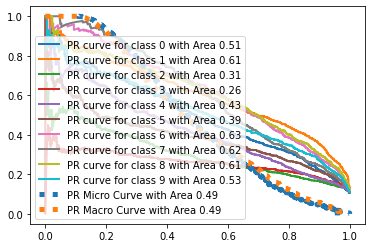

In [105]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
plt.plot(prc['macro'],rcl['macro'],lw=5,linestyle=":",label='PR Macro Curve with Area %0.2f'%(ap['macro']))
    
plt.legend()

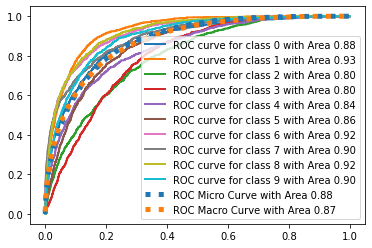

In [106]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
plt.plot(fpr['macro'],tpr['macro'],lw=5,linestyle=":",label='ROC Macro Curve with Area %0.2f'%(roc_auc['macro']))
 
plt.legend()

In [107]:
mAP=np.asanyarray([ap[i] for i in range(10)]).mean()

In [108]:
mAP

0.48925049707419754